<a href="https://colab.research.google.com/github/Mohammad-Amin-Jenadele/gnn-graph-classification/blob/dev/GNN_Graph_classification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and packages

In [2]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.5 MB/s eta 0:00:00


In [54]:
import numpy as np
import copy
import pandas as pd
import torch_geometric
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch.optim.lr_scheduler import ExponentialLR
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn.conv import GCNConv, GINEConv, GATv2Conv
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from torch_geometric.transforms import ToUndirected
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ExponentialLR
from matplotlib.animation import FuncAnimation
from sklearn.manifold import TSNE

# Setting configs and hyperparameters

In [5]:
# Choosing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda


# Data loading and preprocessing

# 📘 OGB MolBace Dataset (Raw)

The dataset **ogbg_molbace** consists of **1513 graphs (molecules)**.  
Each molecule is labeled **0 or 1**, indicating whether it inhibits HIV replication (**1 = active**, **0 = inactive**).

---

## 🔹 Graph structure

- **Nodes = atoms**  
  Each node has **9 features**, representing atom properties such as:
  - Atomic number  
  - Formal charge  
  - Aromaticity  
  - Chirality  
  - Degree  
  - ... and more  

- **Edges = bonds**  
  Each edge has **3 features**, representing bond properties such as:
  - Bond type (single, double, aromatic, etc.)  
  - Bond stereochemistry  
  - Whether the bond is conjugated  

---

## 🔹 Raw CSV files

### 1. `node-feat.csv.gz`
- Shape: **(total_nodes, 9)**  
- Each row = **one atom (node)**  
- Columns = numerical features describing the atom (atomic number, chirality, formal charge, hybridization, aromaticity, etc.)  
- The rows are grouped by graph: first all nodes of graph 0, then graph 1, etc.  

---

### 2. `edge-feat.csv.gz`
- Shape: **(total_edges, 3)**  
- Each row = **one bond (edge)**  
- Columns = numerical features describing the bond:  
  - Bond type (single/double/triple/aromatic)  
  - Bond stereochemistry (e.g., cis/trans)  
  - Conjugation flag (0/1)  
- The rows are aligned with `edge.csv.gz` (row *i* in `edge-feat.csv.gz` corresponds to edge *i* in `edge.csv.gz`).  

---

### 3. `edge.csv.gz`
- Shape: **(total_edges, 2)**  
- Each row = **a directed edge** represented as `[src, dst]` (node indices).  
- Since bonds are undirected, each bond appears **twice**: once as `[u, v]` and once as `[v, u]`.  
- Indices are **local to the graph** (reset per molecule).  

---

### 4. `graph-label.csv.gz`
- Shape: **(num_graphs, 1)**  
- Each row = binary label (0 = inactive, 1 = active).  
- Tells whether the molecule inhibits HIV replication.  

---

### 5. `num-node-list.csv.gz`
- Shape: **(num_graphs, 1)**  
- Each row = number of nodes (atoms) in that graph (molecule).  
- Used to split the long `node-feat.csv.gz` into per-graph chunks.  

---

### 6. `num-edge-list.csv.gz`
- Shape: **(num_graphs, 1)**  
- Each row = number of edges (bonds) in that graph (molecule).  
- Used to split the long `edge.csv.gz` and `edge-feat.csv.gz` into per-graph chunks.  

---


In [6]:
! tar -xvf /content/ogbg_molbace.tar

ogbg_molbace/num-node-list.csv.gz
ogbg_molbace/edge-feat.csv.gz
ogbg_molbace/node-feat.csv.gz
ogbg_molbace/num-edge-list.csv.gz
ogbg_molbace/
ogbg_molbace/graph-label.csv.gz
ogbg_molbace/edge.csv.gz


In [7]:
# preprocessing the raw data
edge_feat_df = pd.read_csv('/content/ogbg_molbace/edge-feat.csv.gz' , compression = 'gzip', header = None)
edge_df = pd.read_csv('/content/ogbg_molbace/edge.csv.gz' , compression = 'gzip', header = None)
graph_label_df = pd.read_csv('/content/ogbg_molbace/graph-label.csv.gz' , compression = 'gzip', header = None)
node_feat_df = pd.read_csv('/content/ogbg_molbace/node-feat.csv.gz' , compression = 'gzip', header = None)
num_edge_list_df = pd.read_csv('/content/ogbg_molbace/num-edge-list.csv.gz' , compression = 'gzip', header = None)
num_node_list_df = pd.read_csv('/content/ogbg_molbace/num-node-list.csv.gz' , compression = 'gzip', header = None)

In [8]:
edge_feat_df

,0,1,2
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,1
...,...,...,...
55763,0,0,0
55764,0,0,1
55765,3,0,1
55766,0,0,0


In [9]:
edge_df

,0,1
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
...,...,...
55763,18,19
55764,5,20
55765,9,1
55766,19,17


In [10]:
graph_label_df

,0
0,1
1,1
2,1
3,1
4,1
...,...
1508,0
1509,0
1510,0
1511,0


In [11]:
node_feat_df

,0,1,2,3,4,5,6,7,8
0,7,0,2,5,0,0,2,0,1
1,5,0,4,5,2,0,2,0,1
2,5,0,4,5,2,0,2,0,1
3,5,1,4,5,1,0,2,0,1
4,6,0,3,5,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
51572,5,0,4,5,2,0,2,0,0
51573,5,0,4,5,1,0,2,0,1
51574,5,0,4,5,2,0,2,0,1
51575,5,0,4,5,2,0,2,0,1


In [12]:
num_edge_list_df

,0
0,35
1,50
2,46
3,42
4,48
...,...
1508,27
1509,27
1510,21
1511,27


In [13]:
num_node_list_df

,0
0,32
1,47
2,42
3,40
4,44
...,...
1508,25
1509,25
1510,19
1511,24


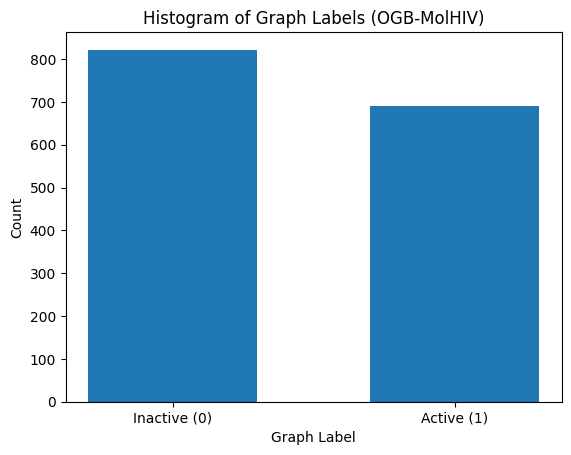

In [14]:
# Count labels
counts = graph_label_df[0].value_counts().sort_index()
# Plot as bar chart
plt.bar([0, 1], counts, width=0.6)
plt.xticks([0, 1], ["Inactive (0)", "Active (1)"])
plt.xlabel("Graph Label")
plt.ylabel("Count")
plt.title("Histogram of Graph Labels (OGB-MolHIV)")
plt.show()

## Loading the data in pytorch geometric format

In [74]:
nodes, edges, edge_features = [], [], []
transform = ToUndirected()
# Process nodes
node_start = 0
for num_nodes in num_node_list_df[0]:
    node_end = node_start + num_nodes
    nodes.append(node_feat_df.iloc[node_start:node_end, :])
    node_start = node_end  # update for next graph

# Process edges and edge features
edge_start = 0
for num_edges in num_edge_list_df[0]:
    edge_end = edge_start + num_edges
    edges.append(edge_df.iloc[edge_start:edge_end, :])
    edge_features.append(edge_feat_df.iloc[edge_start:edge_end, :])
    edge_start = edge_end

# Create PyG graphs
graphs = []
for i in range(len(graph_label_df)):
    g = Data(
        x=torch.tensor(nodes[i].values, dtype=torch.float),
        edge_index=torch.tensor(edges[i].values, dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_features[i].values, dtype=torch.float),
        y=torch.tensor(graph_label_df.iloc[i].values, dtype=torch.float),
    )
    g.graph_id = i
    graphs.append(transform(g))

In [75]:
print(len(graphs))

1513


## Visualizing Some graphs

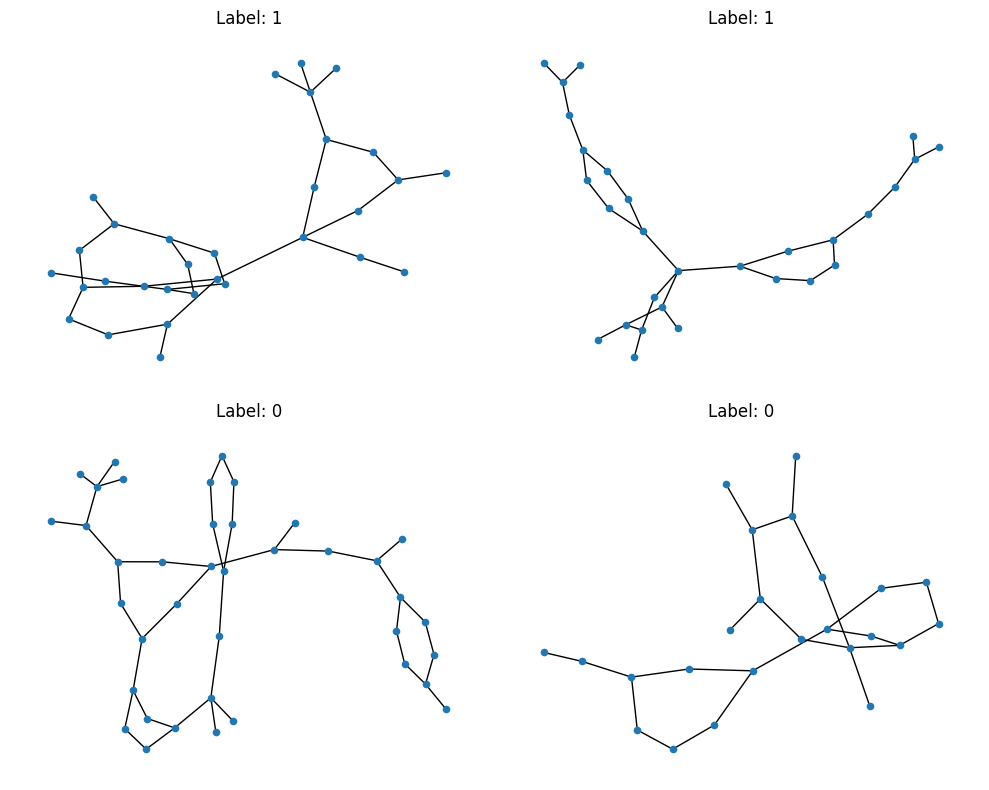

In [76]:
# Separate graphs by label
graphs_label1 = [g for g in graphs if int(g.y.item()) == 1]
graphs_label0 = [g for g in graphs if int(g.y.item()) == 0]

# Randomly choose 2 graphs from each group
chosen_graphs = random.sample(graphs_label1, 2) + random.sample(graphs_label0, 2)

# Plot them (2x2 grid)
plt.figure(figsize=(10, 8))
for i, graph in enumerate(chosen_graphs, 1):
    G = to_networkx(graph, to_undirected=True)
    plt.subplot(2, 2, i)
    nx.draw(G, node_size=20, with_labels=False)
    plt.title(f"Label: {int(graph.y.item())}")
plt.tight_layout()
plt.show()

In [93]:
# Making train-val split
train_graphs, val_graphs = train_test_split(graphs, test_size=0.2, shuffle=True)
train_loader = DataLoader(train_graphs, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1024, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 1024
DataBatch(x=[34814, 9], edge_index=[2, 75292], edge_attr=[75292, 3], y=[1024], graph_id=[1024], batch=[34814], ptr=[1025])

Step 2:
Number of graphs in the current batch: 186
DataBatch(x=[6246, 9], edge_index=[2, 13502], edge_attr=[13502, 3], y=[186], graph_id=[186], batch=[6246], ptr=[187])



In [78]:
graphs[0]

Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], y=[1], graph_id=0)

In [79]:
input_dim = graphs[0].x.shape[1]
edge_dim = graphs[0].edge_attr.shape[1]
aggr=['mean', 'max', 'std', 'var']
print(f'input_dim: {input_dim}')
print(f'edge_dim: {edge_dim}')
print(f'aggr: {aggr}')

input_dim: 9
edge_dim: 3
aggr: ['mean', 'max', 'std', 'var']


# Model Config

In [87]:
class Model:
    def __init__(self, GNN_model, device):
        self.GNN_model = GNN_model.to(device)
        self.device = device

        self.embeddings = []
        self.labels = []
        self.epochs = []
        self.train_acc = []
        self.train_auc = []
        self.val_acc = []
        self.val_auc = []

    def train_one_epoch(self, train_loader, optimizer, criterion):
        self.GNN_model.train()
        total_loss = 0.0

        for data in train_loader:
            data = data.to(self.device)
            optimizer.zero_grad()

            out, _ = self.GNN_model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs

        return total_loss / len(train_loader.dataset)

    def evaluate(self, loader):
        self.GNN_model.eval()
        correct = 0
        total = 0
        all_out = []
        all_labels = []
        embeddings, labels = [], []

        with torch.no_grad():
            for data in loader:
                data = data.to(self.device)
                out, emb = self.GNN_model(data.x, data.edge_index, data.edge_attr, data.batch)

                # out is already sigmoid-scaled (0–1)
                probs = out.view(-1).cpu()
                y_true = data.y.view(-1).cpu()

                pred = (probs >= 0.5).float()
                correct += (pred == y_true).sum().item()
                total += data.num_graphs

                all_out.append(probs)
                all_labels.append(y_true)
                embeddings.append(emb.cpu())
                labels.append(data.y.cpu())

        all_out = torch.cat(all_out)
        all_labels = torch.cat(all_labels)

        try:
            roc_auc = roc_auc_score(all_labels.numpy(), all_out.numpy())
        except ValueError:
            roc_auc = float('nan')

        acc = correct / total
        return acc, roc_auc, torch.cat(embeddings, dim=0), torch.cat(labels, dim=0)

    def train(self, lr, epochs, train_loader, val_loader):
        optimizer = torch.optim.AdamW(self.GNN_model.parameters(), lr=lr)
        scheduler = ExponentialLR(optimizer, gamma=0.9999)
        criterion = torch.nn.BCELoss()

        for epoch in range(epochs):
            loss = self.train_one_epoch(train_loader, optimizer, criterion)
            train_acc, train_auc, _, _ = self.evaluate(train_loader)
            val_acc, val_auc, emb, labels = self.evaluate(val_loader)
            self.train_acc.append(train_acc)
            self.train_auc.append(train_auc)
            self.val_acc.append(val_acc)
            self.val_auc.append(val_auc)


            scheduler.step()

            if (epoch) % 100 == 0:
                print(
                    f"Epoch: {epoch:03d}, "
                    f"Loss: {loss:.4f}, "
                    f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
                    f"Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}, "
                    f"LR: {optimizer.param_groups[0]['lr']}"
                )

            if (epoch) % 50 == 0:
                self.embeddings.append(emb)
                self.labels.append(labels)
                self.epochs.append(epoch)


In [88]:
def animate_embedding(model, interval=800, save_path=None, perplexity=30):
    """
    Creates an animated t-SNE visualization of graph embeddings across epochs.

    Args:
        model: The trained Model object containing embeddings, labels, and epochs.
        interval (int): Delay between frames in milliseconds (default=800).
        save_path (str, optional): If provided, saves the animation as a GIF.
        perplexity (int): t-SNE perplexity parameter (default=30).
    """
    if not model.embeddings:
        print("No embeddings found. Train the model and store embeddings first.")
        return

    # --- Prepare embeddings ---
    embeddings = [emb.cpu().numpy() for emb in model.embeddings]
    labels = [lab.cpu().numpy() for lab in model.labels]
    epochs = model.epochs

    # Ensure equal size
    min_len = min(len(e) for e in embeddings)
    embeddings = [e[:min_len] for e in embeddings]
    labels = [l[:min_len] for l in labels]

    all_emb = np.concatenate(embeddings, axis=0)

    # --- Compute global t-SNE ---
    tsne_model = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    all_emb_2d = tsne_model.fit_transform(all_emb)

    # Split per epoch
    step = min_len
    tsne_results = [all_emb_2d[i*step:(i+1)*step] for i in range(len(embeddings))]


    # --- Global axis limits ---
    x_min = all_emb_2d[:,0].min() - 0.05
    x_max = all_emb_2d[:,0].max() + 0.05
    y_min = all_emb_2d[:,1].min() - 0.05
    y_max = all_emb_2d[:,1].max() + 0.05

    # --- Setup figure ---
    fig, ax = plt.subplots(figsize=(6,6))
    scatter = ax.scatter([], [], s=25)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([])
    ax.set_yticks([])
    title = ax.set_title("t-SNE Embedding Evolution", fontsize=14)
    # Legend for labels
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0],[0], marker='o', color='w', label='Label 0', markerfacecolor='red', markersize=8),
                       Line2D([0],[0], marker='o', color='w', label='Label 1', markerfacecolor='blue', markersize=8)]
    ax.legend(handles=legend_elements, loc='upper right')

    # --- Animation functions ---
    def init():
        scatter.set_offsets(np.empty((0,2)))
        return scatter,

    def update(frame):
        emb_2d = tsne_results[frame]
        lab = labels[frame]
        colors = np.array(['red' if l==0 else 'blue' for l in lab])
        scatter.set_offsets(emb_2d)
        scatter.set_color(colors)
        title.set_text(f"t-SNE Embeddings — Epoch {epochs[frame]}")
        return scatter,

    # --- Build animation ---
    ani = FuncAnimation(
        fig,
        update,
        frames=len(tsne_results),
        init_func=init,
        interval=interval,
        blit=True,
        repeat=True
    )

    # --- Save or show animation ---
    fps = max(1, int(1000/interval))
    if save_path:
        ani.save(save_path, writer="pillow", fps=fps)
        print(f"✅ Animation saved to {save_path}")
    else:
        plt.show()


In [100]:
def plot_training_metrics(model):
    """
    Plots training and validation accuracy and ROC-AUC across all epochs.

    Args:
        model: Instance of the Model class containing train_acc, val_acc,
               train_auc, val_auc lists.
    """
    epochs = range(len(model.train_acc))  # one entry per epoch

    plt.figure(figsize=(10,5))

    # --- Accuracy ---
    plt.plot(epochs, model.train_acc, label="Train Acc", color="blue", linewidth=2)
    plt.plot(epochs, model.val_acc, label="Val Acc", color="red", linewidth=2)

    # --- ROC-AUC ---
    plt.plot(epochs, model.train_auc, label="Train AUC", color="cyan", linestyle='--', linewidth=2)
    plt.plot(epochs, model.val_auc, label="Val AUC", color="magenta", linestyle='--', linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.ylim(0, 1.0)
    plt.title("Training Metrics Across Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()


### GINE

In [95]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, output_dim, embed_dim=None):
        super().__init__()
        self.embed_is_available = embed_dim is not None

        layers = []
        in_dim = input_dim
        for h_dim in hidden_channels:
            layers.append(torch.nn.Linear(in_dim, h_dim))
            layers.append(torch.nn.BatchNorm1d(h_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=0.2))
            in_dim = h_dim

        if self.embed_is_available:
            # Feature extractor with embedding
            feature_layers = layers + [
                torch.nn.Linear(in_dim, embed_dim),
                torch.nn.BatchNorm1d(embed_dim),
                torch.nn.ReLU()
            ]
            self.feature_extractor = torch.nn.Sequential(*feature_layers)
            self.output_layer = torch.nn.Linear(embed_dim, output_dim)
        else:
            # Only one sequential network
            final_layers = layers + [torch.nn.Linear(in_dim, output_dim)]
            self.network = torch.nn.Sequential(*final_layers)

        self.in_channels = input_dim

    def forward(self, x):
        if self.embed_is_available:
            embedding = self.feature_extractor(x)
            out = self.output_layer(embedding)
            return out, embedding
        else:
            out = self.network(x)
            return out


class GINE_GNN_MODEL(torch.nn.Module):
    def __init__(self, input_dim, GINE_MLP_hidden_channels, last_MLP_hidden_channels ,last_mlp_embed_dim, edge_dim, aggr_kwargs=None):
        super().__init__()
        self.linear = torch.nn.Linear(edge_dim , input_dim)

        # --- GINEConv layers ---
        self.conv1 = GINEConv(
            nn=MLP(input_dim, GINE_MLP_hidden_channels, input_dim),
            eps=0.5,
            train_eps=True,
            edge_dim=input_dim
        )

        self.conv2 = GINEConv(
            nn=MLP(input_dim, GINE_MLP_hidden_channels, input_dim),
            eps=0.5,
            train_eps=True,
            edge_dim=input_dim
        )

        # --- Final MLP ---
        self.last_MLP = MLP(input_dim , last_MLP_hidden_channels, 1 , last_mlp_embed_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        edge_attr = self.linear(edge_attr)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.dropout(x, p=0.4, training=self.training)
        x = global_mean_pool(x, batch)
        out , embedding = self.last_MLP(x)
        out = torch.sigmoid(out).view(-1)
        return out, embedding


In [96]:
GINE_MLP_hidden_channels = [32,64,64]
last_MLP_hidden_channels = [32,64]
last_mlp_embed_dim = 16
GINE_GNN_model = GINE_GNN_MODEL(input_dim,GINE_MLP_hidden_channels,last_MLP_hidden_channels,last_mlp_embed_dim, edge_dim,aggr)
GINE_model = Model(GINE_GNN_model, device)

In [97]:
GINE_model.train(lr=3e-3, epochs=10000, train_loader=train_loader, val_loader=val_loader)

Epoch: 000, Loss: 0.6987, Train Acc: 0.4504, Val Acc: 0.4818, Train AUC: 0.4278, Val AUC: 0.4232, LR: 0.0029997
Epoch: 100, Loss: 0.5095, Train Acc: 0.7050, Val Acc: 0.6469, Train AUC: 0.8189, Val AUC: 0.7448, LR: 0.0029698510012725102
Epoch: 200, Loss: 0.4610, Train Acc: 0.8298, Val Acc: 0.7690, Train AUC: 0.8879, Val AUC: 0.8211, LR: 0.002940299019821757
Epoch: 300, Loss: 0.4543, Train Acc: 0.8198, Val Acc: 0.7558, Train AUC: 0.8958, Val AUC: 0.8320, LR: 0.0029110411001294196
Epoch: 400, Loss: 0.4161, Train Acc: 0.8215, Val Acc: 0.7228, Train AUC: 0.8970, Val AUC: 0.8252, LR: 0.0028820743160865385
Epoch: 500, Loss: 0.4033, Train Acc: 0.8207, Val Acc: 0.7558, Train AUC: 0.8905, Val AUC: 0.8275, LR: 0.0028533957707008663
Epoch: 600, Loss: 0.3971, Train Acc: 0.7793, Val Acc: 0.7459, Train AUC: 0.8893, Val AUC: 0.8361, LR: 0.0028250025958071476
Epoch: 700, Loss: 0.3915, Train Acc: 0.8430, Val Acc: 0.7822, Train AUC: 0.9164, Val AUC: 0.8485, LR: 0.0027968919517802767
Epoch: 800, Loss: 0.3

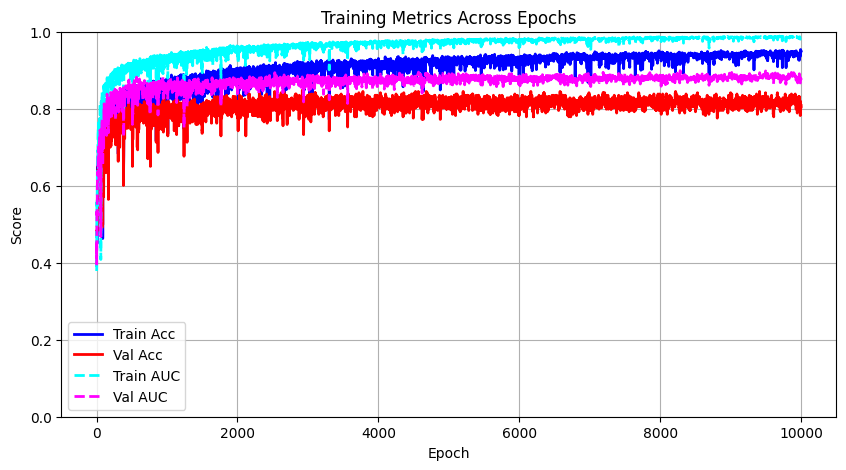

In [101]:
plot_training_metrics(GINE_model)

✅ Animation saved to embedding_evolution.gif


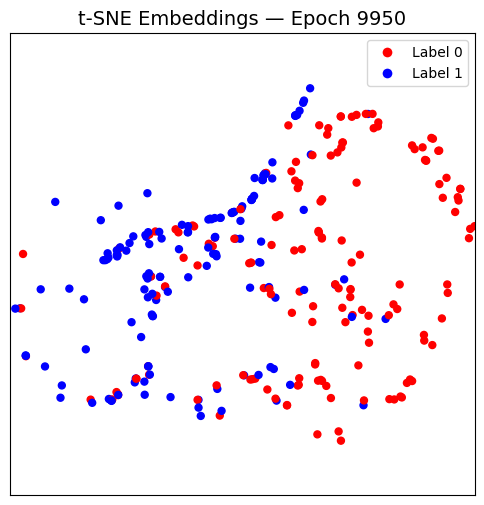

In [99]:
animate_embedding(GINE_model, interval=300, save_path="embedding_evolution.gif")